# Quantitative analysis of storm and dynamo methods on unsteady simulation data

In [1]:
import numpy as np

np.random.seed(0)
import dynamo as dyn

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Generate simulation data and pre-process

In [2]:
def make_sto_sim(alpha, gamma, t_switch, t_obs, labeling_time):
    # Simulate chemical master equation using Gillespie algorithm
    def alpha_fun(t):
        if t < t_switch:
            return alpha
        elif t >= t_switch:
            return 0.00001

    t_cur = 0.0
    x_cur = 0
    new_cur = 0

    # total = np.zeros(1)
    # new = np.zeros(1)

    while (t_cur < t_obs):
        alpha_t = alpha_fun(t_cur)
        a0 = alpha_t + gamma * x_cur
        delta_t = np.random.exponential(scale=1 / a0)
        t_cur = t_cur + delta_t
        if t_cur > t_obs:
            break
        temp = np.random.rand()
        if temp < (alpha_t / a0):
            x_cur = x_cur + 1
            if t_cur > (t_obs - labeling_time):
                new_cur = new_cur + 1
        else:
            if t_cur > (t_obs - labeling_time):
                if np.random.rand() < (new_cur / x_cur):
                    new_cur = new_cur - 1
            x_cur = x_cur - 1

    return x_cur, new_cur, alpha_fun(t_obs), gamma

In [3]:
n_gene = 1000
n_obs = 2000
T = 20 # max observation time
total = np.zeros((n_obs, n_gene))
new = np.zeros((n_obs, n_gene))
alpha_obs = np.zeros((n_obs, n_gene))
alpha = np.random.rand(n_gene) + 0.5
gamma = 0.5 * np.random.rand(n_gene) + 0.01
t_switch = 0.5*np.random.rand(n_gene)/gamma 

In [4]:
labeling_time = np.zeros(n_obs)
labeling_time_choice = np.array([0.25, 0.5, 0.75, 1.0])
for i in range(n_obs):
    temp = np.random.rand()
    if temp < 0.25:
        t_cur_cell = labeling_time_choice[0]
    elif (temp >= 0.25 and temp < 0.5):
        t_cur_cell = labeling_time_choice[1]
    elif (temp >= 0.5 and temp < 0.75):
        t_cur_cell = labeling_time_choice[2]
    else:
        t_cur_cell = labeling_time_choice[3]
    labeling_time[i] = t_cur_cell

In [5]:
t_obs = np.sort(np.random.rand(n_obs) * (1 - 1.0 / T) * T + 1.0) # observation time

In [6]:
# run Gillespie algorithm
for i in range(n_gene):
    for j in range(n_obs):
        total_i_j, new_i_j, alpha_obs_i_j, gamma_i = make_sto_sim(alpha=alpha[i], gamma=gamma[i], t_switch=t_switch[i],
                                                                  t_obs=t_obs[j], labeling_time=labeling_time[j])
        total[j, i], new[j, i], alpha_obs[j, i] = total_i_j, new_i_j, alpha_obs_i_j

In [7]:
# generate adata
import anndata as ad
from scipy.sparse import csr_matrix

total = csr_matrix(total)
adata = ad.AnnData(total)
adata.layers['new'] = csr_matrix(new)
adata.layers['total'] = total
adata.obs['time'] = labeling_time
adata.obs['order'] = np.arange(n_obs)
adata.var['true_gamma'] = gamma

# technical noise is not considered, so the size factor is set to 1
cell_total = total.sum(axis=1).A1
adata.obs['Size_Factor'] = np.ones_like(labeling_time)
adata.obs['initial_cell_size'] = np.ones_like(labeling_time) * np.median(cell_total)
adata.obs['total_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_total_cell_size'] = adata.obs['initial_cell_size']
adata.obs['new_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_new_cell_size'] = adata.obs['initial_cell_size']
adata.obs['obs_time'] = t_obs

/tmp/ipykernel_28779/3115696842.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(total)


In [8]:
adata_storm = adata.copy()
adata_dynamo = adata.copy()
del adata

## Use Storm and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [9]:
# for Storm
dyn.tl.recipe_kin_data(adata=adata_storm,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_CSP',
                       # est_method='CSP4ML_CSZIP',
                       )

dyn.tl.reduceDimension(adata_storm, reduction_method='umap')
dyn.tl.cell_velocities(adata_storm, enforce=True, vkey='velocity_T', ekey='M_t', basis='pca')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: kin
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 2000 cells passed basic filters.
|-----> filtering gene...
|-----> <insert> pass

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/preprocessing/utils.py:523: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  szfactors = adata.obs[total_szfactor][:, None]


|-----> <insert> pca_fit to uns in AnnData Object.
|-----> <insert> ntr to obs in AnnData Object.
|-----> <insert> ntr to var in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|-----> [recipe_monocle preprocess] in progress: 100.0000%
|-----> [recipe_monocle preprocess] finished [2.0452s]
|-----> calculating first/second moments...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [11.3990s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSP, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 66it [00:00, 182.62it/s]/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/estimation/csc/utils_velocity.py:294: RuntimeWarning: invalid value encountered in double_scalars
  r2, all_r2 = 1 - SS_res_n / SS_tot_n, 1 - all_SS_res_n / all_SS_tot_n
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 626.21it/s]
Infer parameters via maximum likelihood estimation based on the CSP model: 0it [00:00, ?it/s]/home/pqw/pythonProject3/CSP4ML.py:214: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(n * np.log(mu) - mu)
/home/pqw/pythonProject3/CSP4ML.py:214: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(n * np.log(mu) - mu)
Infer parameters via maximum likelihood estimation based on the CSP model: 207it [00:00, 426.05it/s]/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimi

(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [9.4962s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity 

AnnData object with n_obs × n_vars = 2000 × 1000
    obs: 'time', 'order', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'obs_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'true_gamma', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap', 'velocity_pca'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con', 'distances', 'conne

In [10]:
# for dynamo
dyn.tl.recipe_kin_data(adata=adata_dynamo,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='twostep',
                       )

dyn.tl.reduceDimension(adata_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(adata_dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='pca')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: kin
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 2000 cells passed basic filters.
|-----> filtering gene...
|-----> <insert> pass

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/preprocessing/utils.py:523: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  szfactors = adata.obs[total_szfactor][:, None]


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [6.0481s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: twostep, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 73it [00:00, 723.02it/s]/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/estimation/csc/utils_velocity.py:294: RuntimeWarning: invalid value encountered in double_scalars
  r2, all_r2 = 1 - SS_res_n / SS_tot_n, 1 - all_SS_res_n / all_SS_tot_n
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 828.92it/s]


(1000, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [8.1343s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity 

AnnData object with n_obs × n_vars = 2000 × 1000
    obs: 'time', 'order', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'obs_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'true_gamma', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'mean_R2', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap', 'velocity_pca'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con', 'distances', 'connectivities', 'pear

## Visualization

Change the settings for better visualization:

In [11]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
path = './rev_figures/figure4/streamline/'

### Streamline plots in PCA space

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/plot/scVectorField.py:1168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

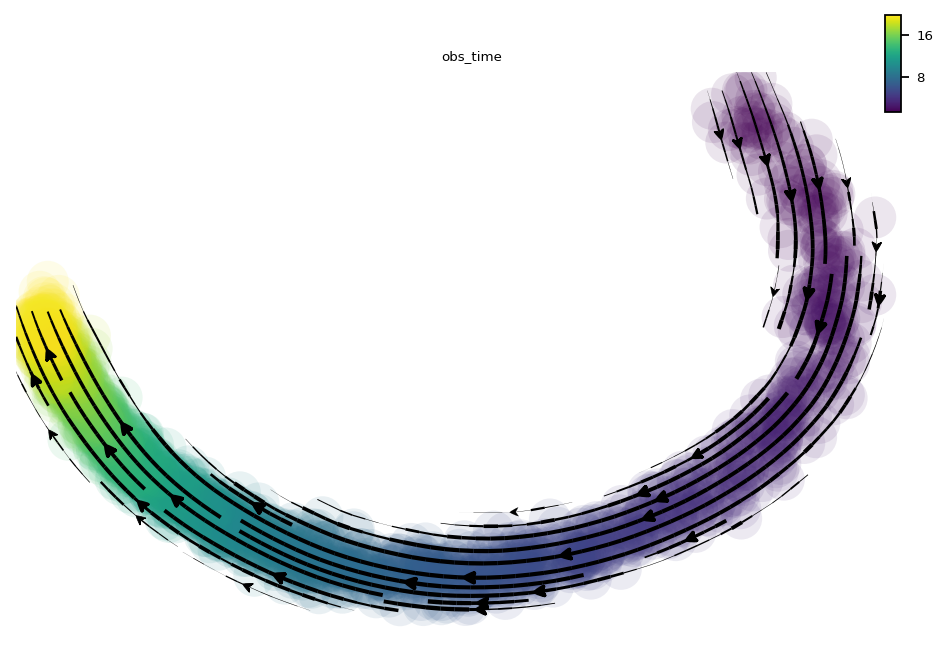

In [12]:
# storm 
dyn.pl.streamline_plot(adata_storm,  basis='pca', color='obs_time',
                       save_show_or_return='show', save_kwargs={'prefix': 'sim_pulse_pca_storm', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/dynamo/plot/scVectorField.py:1168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

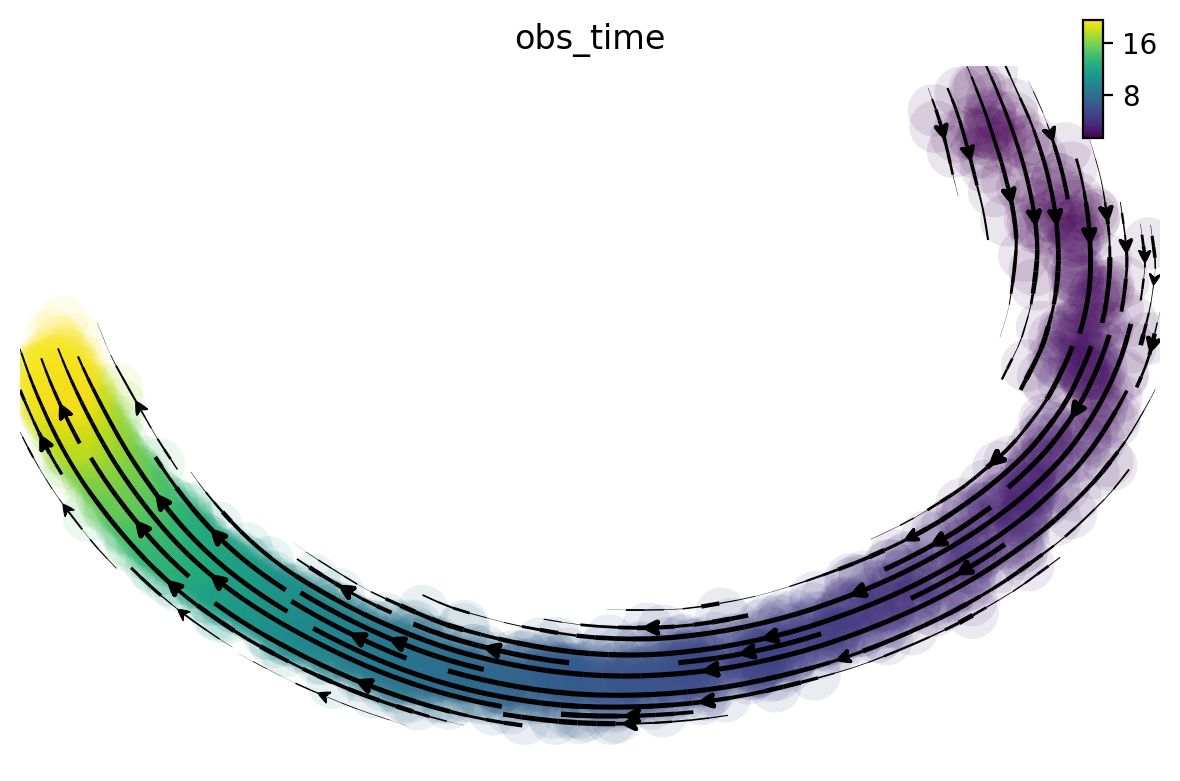

In [13]:
# storm 
dyn.pl.streamline_plot(adata_dynamo,  basis='pca', color='obs_time',
                       save_show_or_return='show', save_kwargs={'prefix': 'sim_pulse_pca_dynamo', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

### Compare the degradation rate $\gamma_{t}$ of each method with the ground truth

In [14]:
gamma_storm = adata_storm.var['gamma'].values
gamma_dynamo = adata_dynamo.var['gamma'].values
gamma_gt = gamma

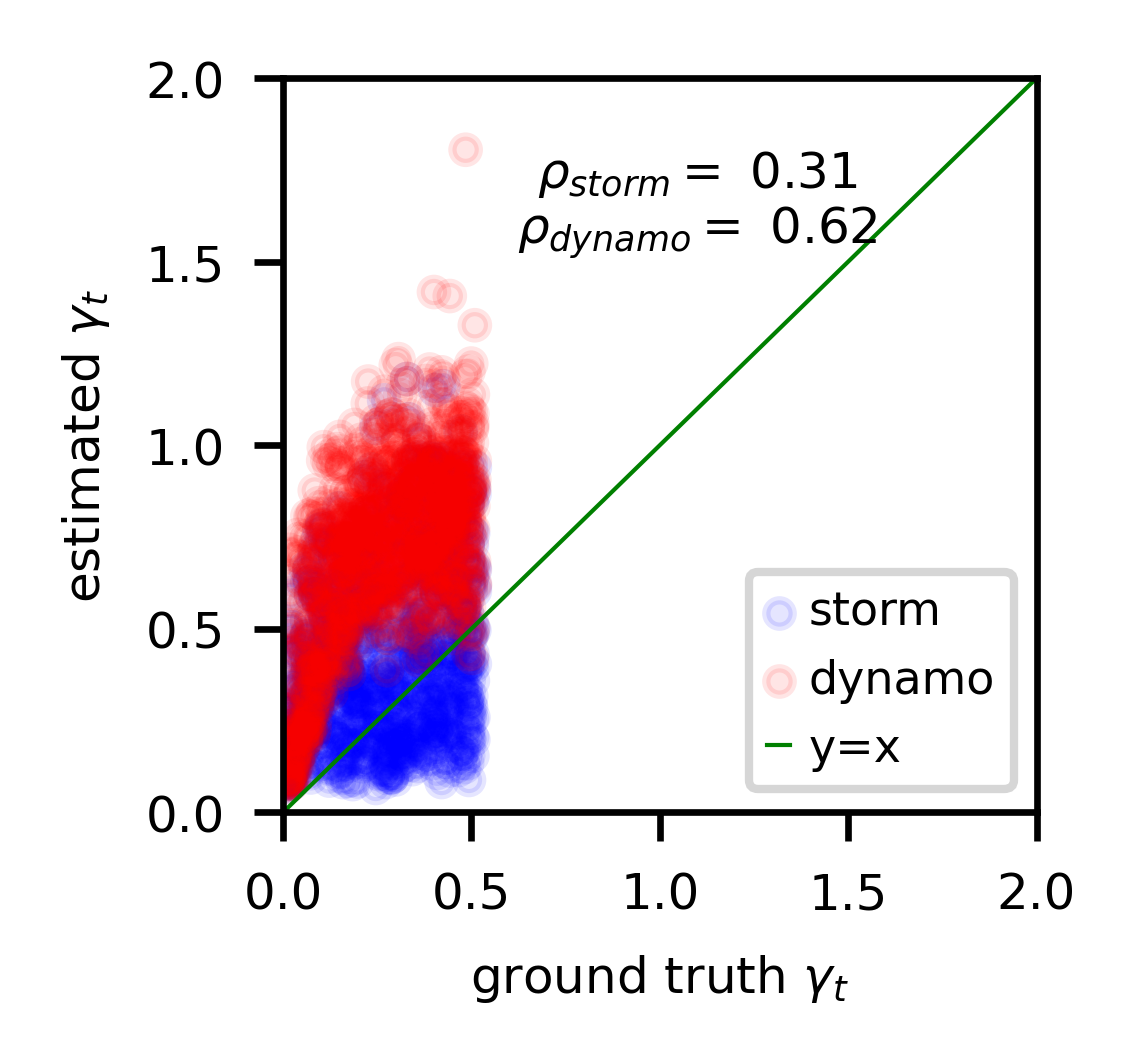

In [15]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.1
dpi = 300

gamma_storm = gamma_storm.astype('float')
gamma_dynamo = gamma_dynamo.astype('float')


range_min = 0
range_max = 2
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_storm), np.isfinite(gamma_dynamo))

# correlation coefficient between all the genes
rho_storm = np.corrcoef(gamma_storm[index_no_nan], gamma_gt[index_no_nan])
rho_dynamo = np.corrcoef(gamma_dynamo[index_no_nan], gamma_gt[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_gt, gamma_storm, color='blue', s=scatter_size * np.ones(len(gamma_storm)), 
           alpha=alpha, label = 'storm')
ax.scatter(gamma_gt, gamma_dynamo, color='red', s=scatter_size * np.ones(len(gamma_dynamo)), 
          alpha=alpha, label = 'dynamo')
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
# plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.55, 0.87, '$\\rho_{storm}=$ %4.2f' % rho_storm[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='black')
plt.text(0.55, 0.79, '$\\rho_{dynamo}=$ %4.2f' % rho_dynamo[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='black')
plt.xlabel('ground truth $\gamma_t$ ')
plt.ylabel('estimated $\gamma_t$')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()
plt.grid(False)
# plt.savefig('./rev_figures/figure4/comp/sim_pulse_scatter.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

Plot the distribution of the difference between the estimate and the true value

In [16]:
import seaborn as sns

/tmp/ipykernel_28779/2751891138.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gamma_storm - gamma_gt,
/tmp/ipykernel_28779/2751891138.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gamma_storm[index_storm_well_fitted] - gamma_gt[index_storm_well_fitted],
/tmp/ipykernel_28779/2751891138.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gamma_dynamo - gamma_gt,
/tmp/ipykernel_28779/2751891138.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gamma_dynamo[index_dynamo_well_fitted] - ga

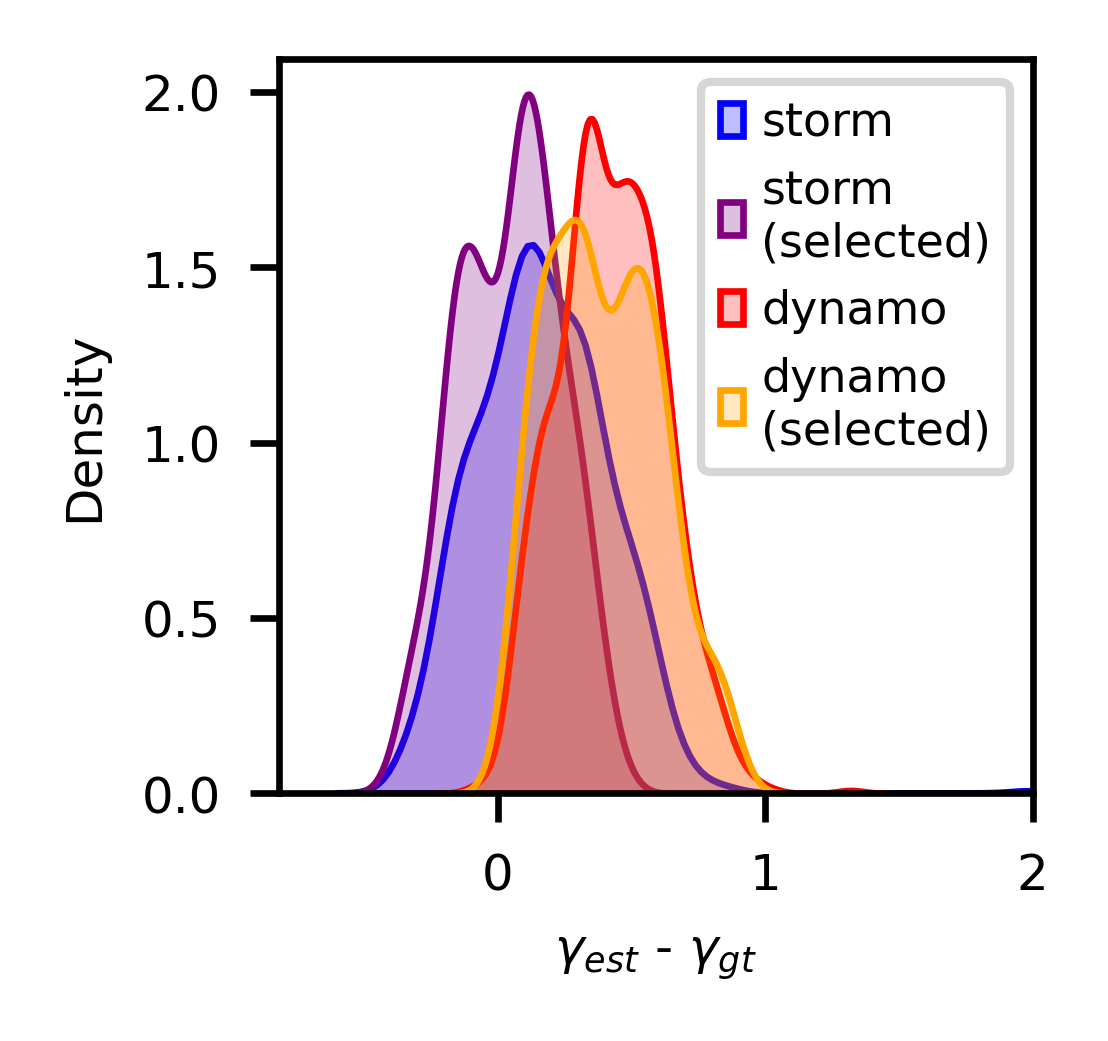

In [32]:
index_storm_well_fitted = adata_storm.var.use_for_transition
index_dynamo_well_fitted = adata_dynamo.var.use_for_transition

fig = plt.figure(2, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
sns.kdeplot(gamma_storm - gamma_gt, 
            shade=True, ax=ax, color='blue', label='storm', linewidth=0.8)
sns.kdeplot(gamma_storm[index_storm_well_fitted] - gamma_gt[index_storm_well_fitted], 
            shade=True, ax=ax, color='purple', label='storm\n(selected)', linewidth=0.8)
sns.kdeplot(gamma_dynamo - gamma_gt, 
            shade=True, ax=ax, color='red', label='dynamo', linewidth=0.8)
sns.kdeplot(gamma_dynamo[index_dynamo_well_fitted] - gamma_gt[index_dynamo_well_fitted], 
            shade=True, ax=ax, color='orange', label='dynamo\n(selected)', linewidth=0.8)
plt.xlabel('$\gamma_{est}$ - $\gamma_{gt}$')
plt.legend(loc='best')
plt.grid(False)
plt.xlim(None,2)
# plt.savefig('./rev_figures/figure4/comp/sim_pulse_kdeplot.pdf', dpi=dpi, bbox_inches="tight")
plt.show()

mean absolute error (mae):

In [18]:
# storm
np.mean(np.abs(gamma_storm[index_no_nan]-gamma_gt[index_no_nan]))

0.23705708438354894

In [19]:
# dynamo
np.mean(np.abs(gamma_dynamo[index_no_nan]-gamma_gt[index_no_nan]))

0.4211276645487344

In [20]:
# storm well fitted
np.mean(np.abs(gamma_storm[index_storm_well_fitted]-gamma_gt[index_storm_well_fitted]))

0.16245480075172491

In [21]:
# dynamo well fitted
np.mean(np.abs(gamma_dynamo[index_dynamo_well_fitted]-gamma_gt[index_dynamo_well_fitted]))

0.39453111203670665